(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [207]:
# Load project package
@load_pkg Antibiotic

import Revise
# Import project package
import Antibiotic 

# Import package to save outputs
import BSON

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import XLSX

# Import library to list files
import Glob

# Import packages to work with data
import DataFrames as DF

# Import statistical functions
import Random
import StatsBase

# Import basic math
import LinearAlgebra

# Import ML libraries
import Flux
import NNlib
import SimpleChains

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.pboc_makie!()

# Exploratory data analysis for Maeda et al., 2020 Nature Communications

In this notebook we will explore the resistance dataset from the [nature
communications](https://www.nature.com/articles/s41467-020-19713-w) paper by
Maeda et al.

First, we will explore the IC50 data. Let's load the tidy data frame.

In [229]:
# Define data directory
data_dir = "$(git_root())/data/Maeda_2020"

# Load file into memory
df_res = CSV.read("$(data_dir)/maeda_resistance_tidy.csv", DF.DataFrame)

last(df_res, 5)

Row,strain,stress,ic50,background,type,resistance
,String15,String15,Float64,String7,String7,String15
1,5.FOAE2,NMNO,-3.83195,MDS42,evolved,5.FOA
2,NMNOE5,NMNO,3.65591,MDS42,evolved,NMNO
3,NMNOE6,NMNO,4.91633,MDS42,evolved,NMNO
4,NMNOE1,NMNO,3.55628,MDS42,evolved,NMNO
5,NMNOE4,NMNO,3.2644,MDS42,evolved,NMNO


## SVD on resistance data

As a first pass through the data, let's perform singular value decomposition on
the resistance data. For this, we need to generate a matrix
$\underline{\underline{R}}$ with the resistance values, where each column
corresponds to one of the strains, and each row to each of the stresses.

In [230]:
# Initialize array to save data
IC50_mat = Matrix{Float32}(
    undef, length(unique(df_res.stress)), length(unique(df_res.strain))
)
# Group data by strain
df_group = DF.groupby(df_res, :strain)

# Extract unique stresses to make sure the matrix is built correctly
stress = sort(unique(df_res.stress))

# Loop through groups
for (i, data) in enumerate(df_group)
    # Sort data by stress
    DF.sort!(data, :stress)
    # Check that the stress are in the correct order
    if all(data.stress .== stress)
        # Add data to matrix
        IC50_mat[:, i] = Float32.(data.ic50)
    else
        println("group $i stress does not match")
    end # if
end # for

# Generate mean-centered matrix
IC50_center = IC50_mat .- StatsBase.mean(IC50_mat, dims=2);

Next, let's compute the singular value decomposition.

In [231]:
# Perform SVD on raw data
U, Σ, V = LinearAlgebra.svd(IC50_mat)

# Perform SVD on mean-centered data
U_center, Σ_center, V_center = LinearAlgebra.svd(IC50_center);

Let's look at the singular value profile.

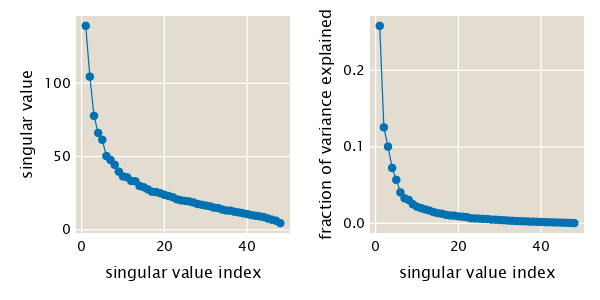

In [232]:
# Initialize figure
fig = Figure(resolution=(600, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="singular value index",
    ylabel="singular value",
    # yscale=log10,
)
ax2 = Axis(
    fig[1, 2],
    xlabel="singular value index",
    ylabel="fraction of variance explained",
    # yscale=log10,
)

# Plot singular value spectrum
scatterlines!(ax, Σ)
scatterlines!(ax2, Σ_center .^2 ./ sum(Σ_center .^2))

fig

## Training 20D IRMAE on data

As an alternative to the SVD approach, let's instead attempt to train an
intrinsically rank minimizing autoencoder on this dataset. 

In [233]:
# Define number of epohcs
n_epoch = 50_000_000
# Define how often error should be computd
n_error = 10_000

# Define filename
fname = "$(git_root())/code/processing/irmae_maeda/output/$(n_epoch)_epoch/" *
        "irmae_20dimensions.bson"
# Load model
irmae = BSON.load(fname)[:irmae]
# Load mean squared error
mse = BSON.load(fname)[:mse_flux]
# Load standardized data
data_std = BSON.load(fname)[:data_std];

Before looking at the singular value spectrum, let's look at the mean squared
error as a function of epoch to make sure that the IRMAEs were properly trained.

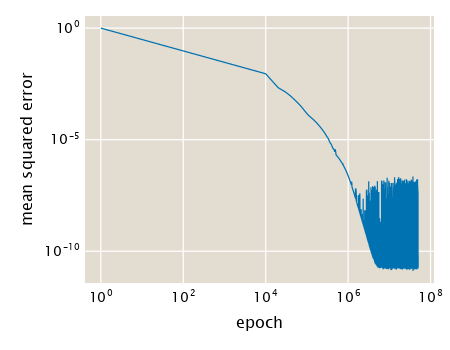

In [234]:
# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axes
ax = Axis(
    fig[1, 1],
    xlabel="epoch",
    ylabel="mean squared error",
    xscale=log10,
    yscale=log10,
)

# Plot error over time
lines!(
    ax, 
    [collect(1:n_error:n_epoch); [n_epoch]],
    mse
)

fig

This training curve look as expected. The longer the model is trained, the
lower the reconstruction mean squared error gets.

Let's compute the singular value decomposition of the latent-space
representation.

In [235]:
# Define number of hidden layers
n_hidden = 4
# Define number of linear layers
n_linear = 8
# Define location of latent-space layer
n_latent = n_hidden + n_linear + 1

# Map data into latent space
data_latent = Flux.activations(irmae, data_std)[n_latent]

# Generate mean-centered latent space data
data_latent_center = data_latent .- StatsBase.mean(data_latent, dims=2)

# Perform singular value decomposition
U_latent, Σ_latent, V_latent = LinearAlgebra.svd(data_latent)

# Perform singular value decomposition on mean-centered data
U_latent_center, Σ_latent_center, V_latent_center = LinearAlgebra.svd(
    data_latent_center
);

As with the SVD done on the raw data, let's look at the singular value spectrum
obtained from the latent space representation.

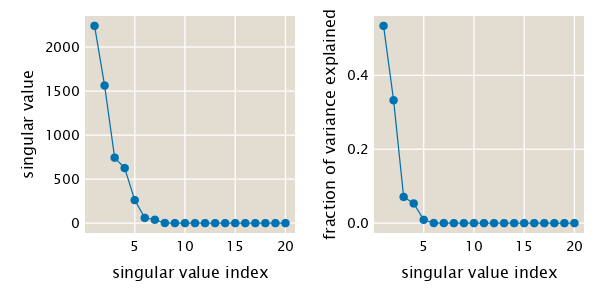

In [236]:
# Initialize figure
fig = Figure(resolution=(600, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="singular value index",
    ylabel="singular value",
    # yscale=log10,
)
ax2 = Axis(
    fig[1, 2],
    xlabel="singular value index",
    ylabel="fraction of variance explained",
    # yscale=log10,
)

# Plot singular value spectrum
scatterlines!(ax, Σ_latent)
scatterlines!(ax2, Σ_latent_center .^2 ./ sum(Σ_latent_center .^2))

fig

The singular value spectrum for the latent space representation is completely 
different. Here, we clearly see that ≈ 4 singular values explain most of the
variance in the data. This strongly suggests that despite the incredibly diverse
set of mutants, we can compress the data into a much lower dimensional space.

Another interesting quantity to compare is the reconstruction error between this
non-linear autoencoder model and an equivalent SVD-based linear model with the
same dimensionality. Let's compute the error for both of these cases.

In [237]:
# Compute the mean squared error when reconstructing the inputs with the trained
# IRMAE
mse_irmae = Flux.mse(irmae(data_std), data_std)

# Compute SVD on the Z-score standardized data
U_std, Σ_std, V_std = LinearAlgebra.svd(data_std)

# Define dimensionality of IRMAE latent space to truncate the linear model to
# the same dimensionality
idx = 20

# Build truncated singular-value diagonal matrix to approximate data.
Σ_std_trunc = zeros(length(Σ_std))
Σ_std_trunc[1:idx] = Σ_std[1:idx]

# Compute the mean squared error for a linear model
mse_svd = Flux.mse(
    data_std, (U_std * LinearAlgebra.Diagonal(Σ_std_trunc) * V_std')
)

println("SVD-based $(idx)D model MSE = $(mse_svd)")
println("IRMAE-based $(idx)D model MSE = $(mse_irmae)")

SVD-based 20D model MSE = 0.15053925930938364
IRMAE-based 20D model MSE = 6.132878e-11


As expected, the non-linear model has a much smaller reconstruction error.

## Training 4D autoencoder on data

Given this suggested 4D latent space, we repeated the training of an autoencoder
with a 4D latent space. Let's load the results.

In [263]:
# Define number of epohcs
n_epoch = 10_000_000
# Define how often error should be computd
n_error = 10_000

# Define filename
fname = "$(git_root())/code/processing/ae_maeda/output/$(n_epoch)_epoch/" *
        "ae_4dimensions.bson"
# Load model
ae = BSON.load(fname)[:ae]
# Load mean squared error
mse = BSON.load(fname)[:mse_flux]
# Load standardized data
data_std = BSON.load(fname)[:data_std];

Next, let's look at the error as a function of the training epoch.

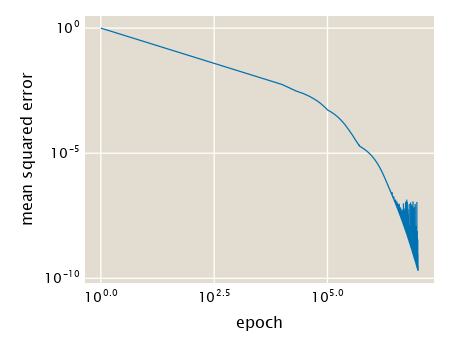

In [270]:
# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axes
ax = Axis(
    fig[1, 1],
    xlabel="epoch",
    ylabel="mean squared error",
    xscale=log10,
    yscale=log10,
)

# Plot error over time
lines!(
    ax, 
    [collect(1:n_error:n_epoch); [n_epoch]],
    mse
)

fig

It looks that we indeed can compress the data really well with only four latent
variables.

Although not necessarily interesting for our analysis, let's compute the SVD of
the latent space representation.

In [271]:
# Define number of hidden layers
n_hidden = 4
# Define number of linear layers
n_linear = 0
# Define location of latent-space layer
n_latent = n_hidden + n_linear + 1

# Map data into latent space
data_latent = Flux.activations(ae, data_std)[n_latent]

# Generate mean-centered latent space data
data_latent_center = data_latent .- StatsBase.mean(data_latent, dims=2)

# Perform singular value decomposition
U_latent, Σ_latent, V_latent = LinearAlgebra.svd(data_latent)

# Perform singular value decomposition on mean-centered data
U_latent_center, Σ_latent_center, V_latent_center = LinearAlgebra.svd(
    data_latent_center
);

Let's take a look at the resulting singular value spectrum.

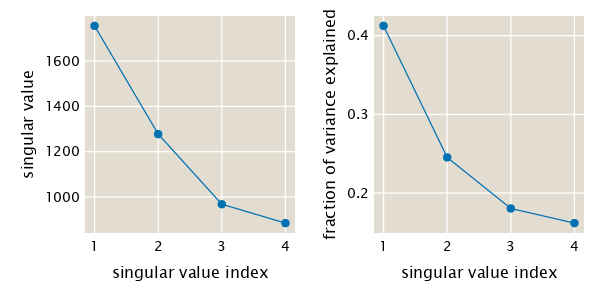

In [272]:
# Initialize figure
fig = Figure(resolution=(600, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="singular value index",
    ylabel="singular value",
    # yscale=log10,
)
ax2 = Axis(
    fig[1, 2],
    xlabel="singular value index",
    ylabel="fraction of variance explained",
    # yscale=log10,
)

# Plot singular value spectrum
scatterlines!(ax, Σ_latent)
scatterlines!(ax2, Σ_latent_center .^2 ./ sum(Σ_latent_center .^2))

fig

Finally, let's compare the reconstruction error between the autoencoder and the
equivalent linear model.

In [273]:
# Compute the mean squared error when reconstructing the inputs with the trained
# autoencoder
mse_ae = Flux.mse(ae(data_std), data_std)

# Compute SVD on the Z-score standardized data
U_std, Σ_std, V_std = LinearAlgebra.svd(data_std)

# Define dimensionality of ae latent space to truncate the linear model to
# the same dimensionality
idx = 4

# Build truncated singular-value diagonal matrix to approximate data.
Σ_std_trunc = zeros(length(Σ_std))
Σ_std_trunc[1:idx] = Σ_std[1:idx]

# Compute the mean squared error for a linear model
mse_svd = Flux.mse(
    data_std, (U_std * LinearAlgebra.Diagonal(Σ_std_trunc) * V_std')
)

println("SVD-based $(idx)D model MSE = $(mse_svd)")
println("autoencoder-based $(idx)D model MSE = $(mse_ae)")

SVD-based 4D model MSE = 0.5437144583181625
autoencoder-based 4D model MSE = 2.7458608e-10


To better explore the resulting latent space, let's generate a tidy dataframe
with the corresponding coordinates.

In [274]:
# Group data by strain
df_group = DF.groupby(df_res, :strain)
# Extract strain names from grouping
strains = [x[:strain] for x in collect(keys(df_group))]
# Extract metadata for each strain
df_meta = unique(df_res[:, DF.Not([:ic50, :stress])])

# Transform matrix to dataframe
df_latent = DF.DataFrame(data_latent, strains)

# Add latent variable name
df_latent[:, :latent] = ["z$(i)" for i = 1:size(data_latent, 1)]

# Transform to tidy data
df_latent_tidy = DF.stack(df_latent, DF.Not(:latent))
# Rename columns
DF.rename!(df_latent_tidy, :variable => :strain)
# Add metadata
DF.leftjoin!(df_latent_tidy, df_meta, on=:strain)

first(df_latent_tidy, 5)

Row,latent,strain,value,background,type,resistance
,String,String,Float32,String7,String7,String15
1,z1,CPE6,5.90323,MDS42,evolved,CP
2,z2,CPE6,136.403,MDS42,evolved,CP
3,z3,CPE6,-53.8312,MDS42,evolved,CP
4,z4,CPE6,-188.305,MDS42,evolved,CP
5,z1,CPE2,-5.72072,MDS42,evolved,CP


Furthermore, an important piece of the metadata we are missing is the type of
stressor under which these strains evolved. For this, we use the table
supplemented with the paper that contains the information on the stressor
chemicals used in the article. We use a more coarse-grained classification of 
the stressors as depicted in their Fig. 2. 

Let's read this metadata into memory. Note: We will modify a bunch of entries 
for both sets to match. This was a manual curation.

In [275]:
# Import chemical classification
df_chem = XLSX.readtable("$(data_dir)/chemical_info.xlsx", "class") |> 
          DF.DataFrame
# Rename columns
DF.rename!(
    df_chem, 
    :Abbreviation => :resistance, 
    Symbol("Biological target") => :target
)
# Replace `-` with `.` to have same convention as other data
df_chem.resistance = replace.(df_chem.resistance, "-" => ".")
# Replace NiCl2 with NiCl to match data
df_chem.resistance = replace.(df_chem.resistance, "NiCl2" => "NiCl")
# Replace K2TeO3 with KTe to match data
df_chem.resistance = replace.(df_chem.resistance, "K2TeO3" => "KTe")



first(df_chem, 10)

Row,resistance,target,class
,String,Any,Any
1,3.AT,Histidine biosynthesis,metabolic inhibitor
2,5.FOA,DNA,dna replication inhibitor
3,5.FU,DNA,dna replication inhibitor
4,6.MP,DNA,dna replication inhibitor
5,ABU,Unknown in bacteria,other
6,AF,DNA,other
7,ATP,Adrenergic uptake (Unknown in bacteria),other
8,AZT,Peptidoglycan,cell wall synthesis inhibitor
9,B.Cl.Ala,"Alanine racemase, Alanine aminotransferase",metabolic inhibitor


Let's add this information to our dataframe.

In [276]:
# Add chemical metadata
DF.leftjoin!(df_latent_tidy, df_chem, on=:resistance)

first(df_latent_tidy, 10)

Row,latent,strain,value,background,type,resistance,target,class
,String,String,Float32,String7,String7,String15,Any,Any
1,z1,CPE6,5.90323,MDS42,evolved,CP,50S ribosome,protein synthesis inhibitor
2,z2,CPE6,136.403,MDS42,evolved,CP,50S ribosome,protein synthesis inhibitor
3,z3,CPE6,-53.8312,MDS42,evolved,CP,50S ribosome,protein synthesis inhibitor
4,z4,CPE6,-188.305,MDS42,evolved,CP,50S ribosome,protein synthesis inhibitor
5,z1,CPE2,-5.72072,MDS42,evolved,CP,50S ribosome,protein synthesis inhibitor
6,z2,CPE2,61.5827,MDS42,evolved,CP,50S ribosome,protein synthesis inhibitor
7,z3,CPE2,-16.329,MDS42,evolved,CP,50S ribosome,protein synthesis inhibitor
8,z4,CPE2,-84.7712,MDS42,evolved,CP,50S ribosome,protein synthesis inhibitor
9,z1,CPE5,41.8719,MDS42,evolved,CP,50S ribosome,protein synthesis inhibitor


With this tidy dataframe in hand, let's look at the latent space locations for
each mutant. To visualize this, we will use a so-called corner plot, implemented
in our `viz` module as `corner_plot!`.

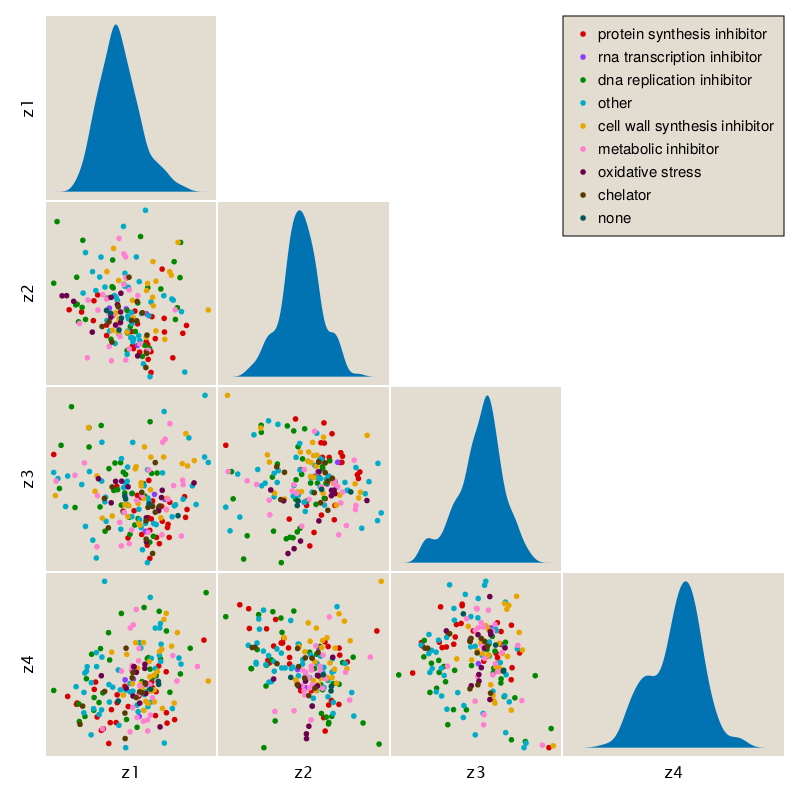

In [295]:
# Initialize figure
fig = Figure(resolution=(800, 800))

Antibiotic.viz.corner_plot!(
    fig,
    df_latent_tidy,
    :latent,
    :value,
    :class,
    ColorSchemes.glasbey_bw_minc_20_maxl_70_n256,
)

fig

192-element Vector{InlineStrings.String15}:
 "CPE6"
 "CPE2"
 "CPE5"
 "CPE3"
 "RFPE4"
 "RFPE1"
 "RFPE3"
 "RFPE2"
 "5.FUE4"
 "5.FUE3"
 ⋮
 "DVALE5"
 "5.FOAE4"
 "5.FOAE6"
 "5.FOAE3"
 "5.FOAE2"
 "NMNOE5"
 "NMNOE6"
 "NMNOE1"
 "NMNOE4"